In [1]:
from pyMesh import hcubeMesh, visualize2D, plotBC, plotMesh,setAxisLabel

====>Check bc nodes!
====>BC nodes pass!
The mesh generation reaches covergence!


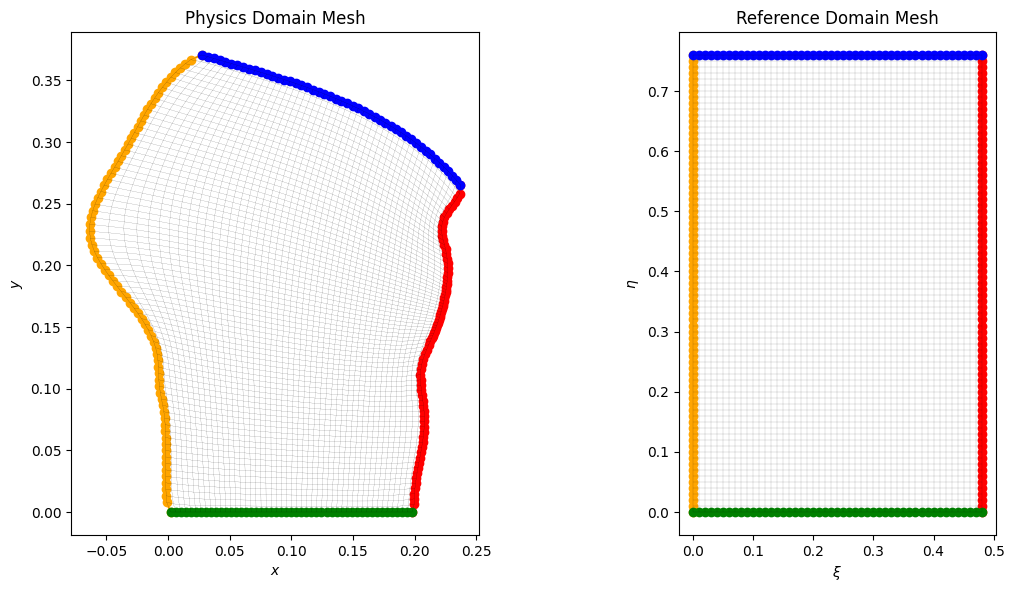

In [2]:
import Ofpp
h=0.01
OFBCCoord=Ofpp.parse_boundary_field(r'TemplateCase_simpleVessel/3200/C.txt')
OFLOWC=OFBCCoord[b'low'][b'value']
OFUPC=OFBCCoord[b'up'][b'value']
OFLEFTC=OFBCCoord[b'left'][b'value']
OFRIGHTC=OFBCCoord[b'rifht'][b'value']

leftX=OFLEFTC[:,0];leftY=OFLEFTC[:,1]
lowX=OFLOWC[:,0];lowY=OFLOWC[:,1]
rightX=OFRIGHTC[:,0];rightY=OFRIGHTC[:,1]
upX=OFUPC[:,0];upY=OFUPC[:,1]
ny=len(leftX);nx=len(lowX)
myMesh=hcubeMesh(leftX,leftY,rightX,rightY,
	             lowX,lowY,upX,upY,h,True,True,
	             tolMesh=1e-10,tolJoint=1e-2)

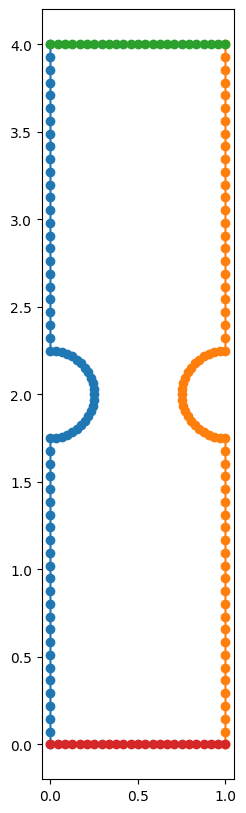

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt


# Define the parameters
y_max = 4
x_max = 1
notch_diameter = 0.5
notch_radius = notch_diameter / 2
notch_height = 2
notch_center1 = (0, 2)
notch_center2 = (1, 2)
n_points = 25

# Generate the top and bottom boundaries
top = np.array([(x, y_max) for x in np.linspace(0, x_max, n_points)])
bottom = np.array([(x, 0) for x in np.linspace(0, x_max, n_points)])

# Generate the left and right boundaries
left_1 = np.array([(0, y) for y in np.linspace(0, notch_height - notch_radius, n_points)])
left_2 = np.array([(0, y) for y in np.linspace(notch_height + notch_radius, y_max, n_points)])
left_circle = np.array([(notch_center1[0] + notch_radius * np.sin(t), notch_center1[1] + notch_radius * np.cos(t)) for t in np.linspace(np.pi, 0, n_points)])[1:-1]
left = np.concatenate([left_1, left_circle, left_2])

right_1 = np.array([(x_max, y) for y in np.linspace(0, notch_height - notch_radius, n_points)])
right_2 = np.array([(x_max, y) for y in np.linspace(notch_height + notch_radius, y_max, n_points)])
right_circle = np.array([(notch_center2[0] + notch_radius * np.sin(t), notch_center2[1] + notch_radius * np.cos(t)) for t in np.linspace(np.pi, 2 * np.pi, n_points)])[1:-1]
right = np.concatenate([right_1, right_circle, right_2])

fig, ax = plt.subplots(1, 1,figsize=(10,10))
plt.plot(left[:,0],left[:,1], marker='o')
plt.plot(right[:,0],right[:,1], marker='o')
plt.plot(top[:,0],top[:,1], marker='o')
plt.plot(bottom[:,0],bottom[:,1], marker='o')

ax.set_aspect('equal')


====>Check bc nodes!
====>BC nodes pass!
The mesh generation reaches covergence!


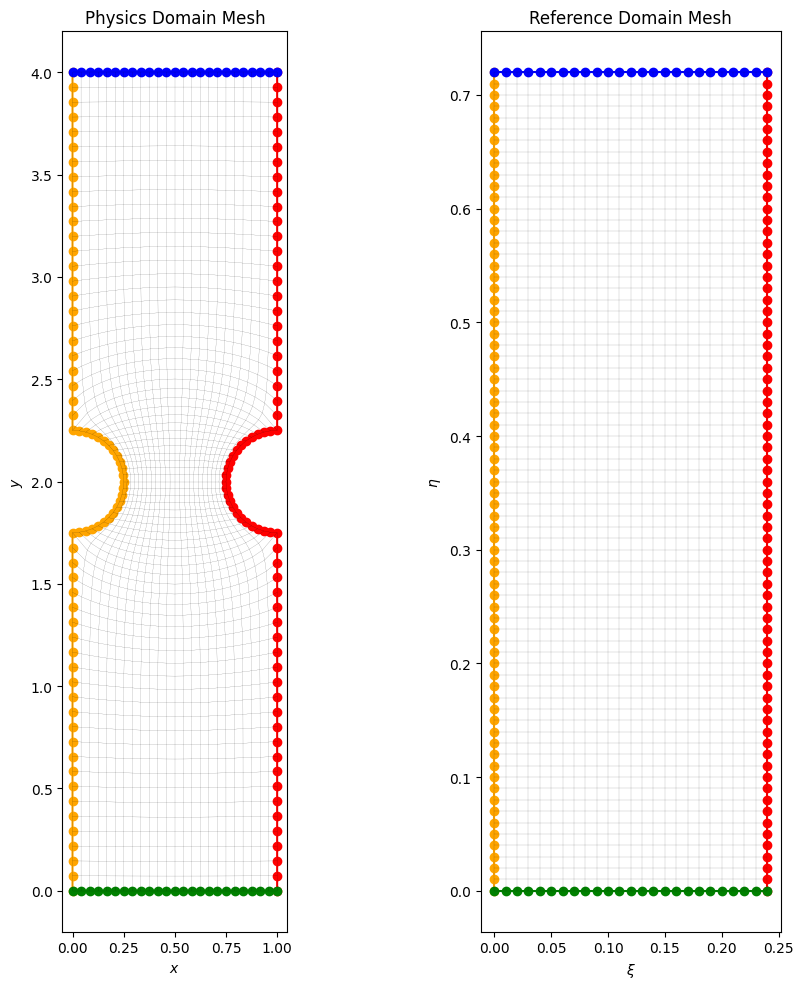

In [4]:
upX=top[:,0];upY=top[:,1]
lowX=bottom[:,0];lowY=bottom[:,1]
leftX=left[:,0];leftY=left[:,1]
rightX=right[:,0];rightY=right[:,1]

ny=len(leftX);nx=len(lowX)
myMesh=hcubeMesh(leftX,leftY,rightX,rightY,
	             lowX,lowY,upX,upY,h,False,False,
	             tolMesh=1e-10,tolJoint=1e-2)

fig, ax = plt.subplots(1, 2,figsize=(10,10))
plotBC(ax[0],myMesh.x,myMesh.y)
plotMesh(ax[0],myMesh.x,myMesh.y)
setAxisLabel(ax[0],'p')
ax[0].set_aspect('equal')
ax[0].set_title('Physics Domain Mesh')

plotBC(ax[1],myMesh.xi,myMesh.eta)
plotMesh(ax[1],myMesh.xi,myMesh.eta)
setAxisLabel(ax[1],'r')
ax[1].set_aspect('equal')
ax[1].set_title('Reference Domain Mesh')
fig.tight_layout()

In [5]:
#save the mesh
data_path = f"deep_notched_{nx}x{ny}.txt"
np.savetxt(data_path, np.hstack((myMesh.x.reshape(-1, 1), myMesh.y.reshape(-1, 1))), delimiter=' ', fmt='%1.16f')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


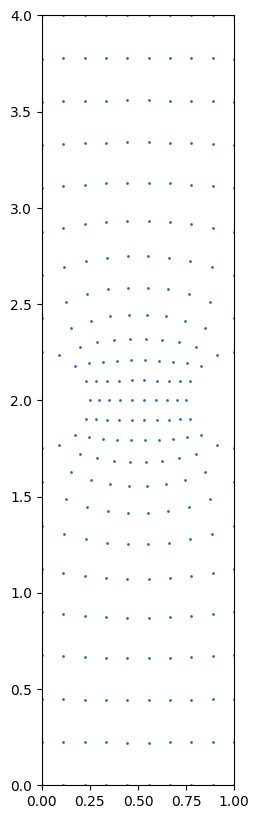

In [6]:
import jax
import jax.numpy as jnp

# Load geometry mapping
nx=25
ny=75
Xp = np.loadtxt(f"../geometry/deep_notched_{nx}x{ny}.txt")

# Interpolate mapping
X_map_points = Xp[:, 0].reshape((ny, nx)).T
Y_map_points = Xp[:, 1].reshape((ny, nx)).T

def coordMap(x):
    x_pos = x[:, 0]/x_max*(nx-1)
    y_pos = x[:, 1]/y_max*(ny-1)

    x_mapped = jax.scipy.ndimage.map_coordinates(X_map_points, [x_pos, y_pos], order=1)
    y_mapped = jax.scipy.ndimage.map_coordinates(Y_map_points, [x_pos, y_pos], order=1)

    return jnp.stack((x_mapped, y_mapped), axis=1)


x_plot = np.linspace(0, x_max, 10)
y_plot = np.linspace(0, y_max, 25)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)
X_plot, Y_plot = X_plot.flatten(), Y_plot.flatten()
X_mapped, Y_mapped = coordMap(jax.numpy.stack((X_plot, Y_plot), axis=1)).T

fig, ax = plt.subplots(1, 1,figsize=(10,10))
plt.scatter(X_mapped, Y_mapped, s=1)
plt.xlim(0, x_max)
plt.ylim(0, y_max)
ax.set_aspect('equal')

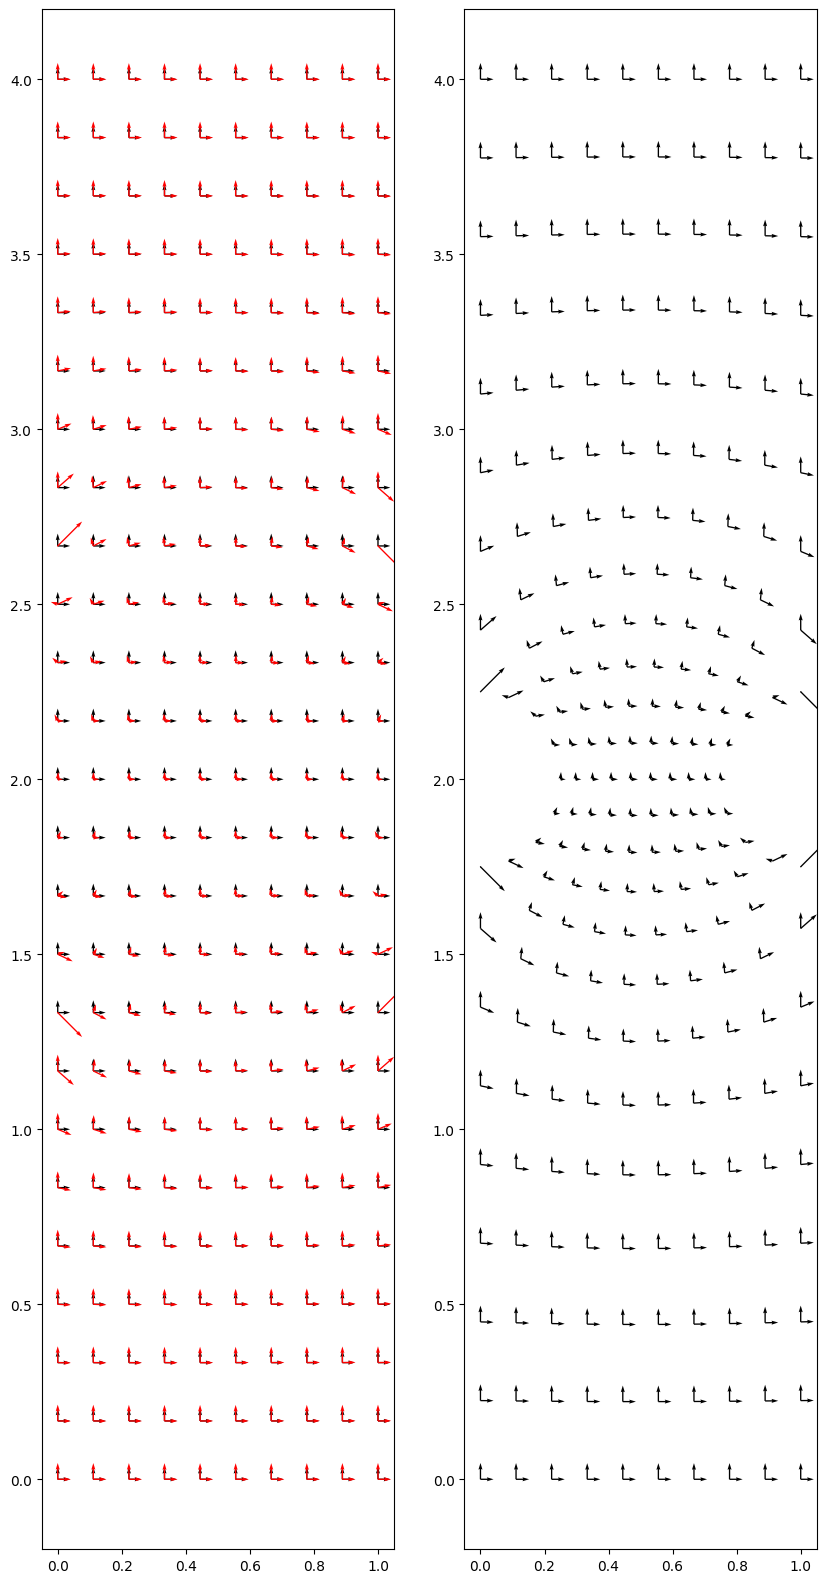

In [7]:
def coordMap(x, padding=1e-6):
    x_pos = x[0]/x_max*(nx-1)*(1-2*padding) + padding
    y_pos = x[1]/y_max*(ny-1)*(1-2*padding) + padding

    x_mapped = jax.scipy.ndimage.map_coordinates(X_map_points, [x_pos, y_pos], order=1, mode='nearest')
    y_mapped = jax.scipy.ndimage.map_coordinates(Y_map_points, [x_pos, y_pos], order=1, mode='nearest')

    return jnp.stack((x_mapped, y_mapped), axis=0)

def tensMap(tens, x):
    J = jax.jacobian(coordMap)(x)
    return J @ tens 

vec1 = jnp.ones(X_mapped.shape)
vec0 = jnp.zeros(X_mapped.shape)

U_1 = jnp.stack((vec1, vec0), axis=1)
U_2 = jnp.stack((vec0, vec1), axis=1)

U1_mapped = jax.vmap(tensMap)(U_1, jnp.stack((X_plot, Y_plot), axis=1)).squeeze()
U2_mapped = jax.vmap(tensMap)(U_2, jnp.stack((X_plot, Y_plot), axis=1)).squeeze()

fig, ax = plt.subplots(1, 2,figsize=(10,20))
ax[0].quiver(X_plot, Y_plot, vec1, vec0)
ax[0].quiver(X_plot, Y_plot, vec0, vec1)

ax[0].quiver(X_plot, Y_plot, U1_mapped[:, 0], U1_mapped[:, 1], color='r')
ax[0].quiver(X_plot, Y_plot, U2_mapped[:, 0], U2_mapped[:, 1], color='r')

ax[1].quiver(X_mapped, Y_mapped, U1_mapped[:, 0], U1_mapped[:, 1])
ax[1].quiver(X_mapped, Y_mapped, U2_mapped[:, 0], U2_mapped[:, 1])

In [115]:
jax.vmap(tensMap)(S, jnp.stack((X_plot, Y_plot), axis=1)).shape

(10000, 2, 2)

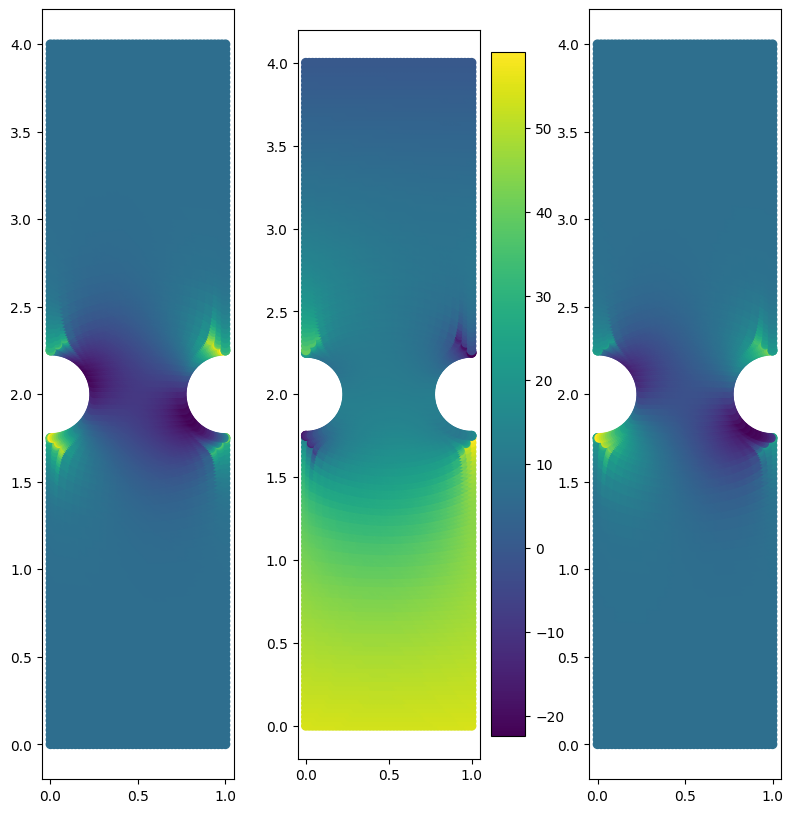

In [127]:
x_plot = np.linspace(0, x_max, 50)
y_plot = np.linspace(0, y_max, 200)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)
X_plot, Y_plot = X_plot.flatten(), Y_plot.flatten()
X_mapped, Y_mapped = jax.vmap(coordMap)(jax.numpy.stack((X_plot, Y_plot), axis=1)).T
pstress = 0
vec1 = jnp.ones(X_mapped.shape)*10
vec0 = jnp.zeros(X_mapped.shape)
Syy = vec1* (y_max - Y_plot) + pstress
S = jnp.stack((vec1, vec1, vec1, Syy), axis=1).reshape(-1, 2, 2)

S_mapped = jax.vmap(tensMap)(S, jnp.stack((X_plot, Y_plot), axis=1))


fig, ax = plt.subplots(1, 3,figsize=(10,10))
ax[0].scatter(X_mapped, Y_mapped, c=S_mapped[:, 0, 0])
ax[0].set_aspect('equal')
im = ax[1].scatter(X_mapped, Y_mapped, c=S_mapped[:, 1, 1])
ax[1].set_aspect('equal')
plt.colorbar(im, ax=ax[1], cmap="coolwarm")
ax[2].scatter(X_mapped, Y_mapped, c=S_mapped[:, 0, 1])
ax[2].set_aspect('equal')





In [97]:
X_mapped.shape

(2,)